In [17]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
import pandas as pd
import requests

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Connect to the IRM.csv

In [4]:
df = pd.read_csv("C:/Users/ankin/Desktop/Reno_Energy_Assessment/Data/IRM.csv", sep=';')
df.isnull().sum()


name          0
date          0
variableId    0
value         0
dtype: int64

In [5]:
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'date': 'datetime'}, inplace=True)
df['datetime'] = df['datetime'].dt.tz_convert('Europe/Brussels')


In [6]:
solar_irradiation_data = df[df['name'].str.contains('Solar irradiation')]
temperature_data = df[df['name'].str.contains('Temperature')]

# Connect to Elia data


In [28]:

url = "https://opendata.elia.be/api/records/1.0/search/"

def fetch_data(start_date, end_date):
    params = {
        "dataset": "ods032",
        "sort": "datetime",
        "refine.region": "Liège",
        "rows": 10000,
        "q": f"datetime:[{start_date} TO {end_date}]"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return [record['fields'] for record in response.json()['records']]
    else:
        print(f"Failed to fetch data for {start_date} to {end_date}: {response.status_code}")
        return []

# Fetch data for each month of 2024
all_data = []
for month in range(1, 13):
    start_date = f"2024-{month:02d}-01T00:00:00Z"
    if month == 12:
        end_date = "2024-12-31T23:59:59Z"
    else:
        end_date = f"2024-{month+1:02d}-01T00:00:00Z"
    print(f"Fetching data for {start_date} to {end_date}...")
    all_data.extend(fetch_data(start_date, end_date))


elia_data = pd.DataFrame(all_data)

elia_data['datetime'] = pd.to_datetime(elia_data['datetime'])


elia_data.set_index('datetime', inplace=True)


numeric_columns = elia_data.select_dtypes(include=['number'])


elia_data_hourly = numeric_columns.resample('h').mean()



# Save to CSV
elia_data_hourly.to_csv("elia_data_2024_hourly.csv", index=True)
print("Data saved to 'elia_data_2024_hourly.csv'.")


Fetching data for 2024-01-01T00:00:00Z to 2024-02-01T00:00:00Z...
Fetching data for 2024-02-01T00:00:00Z to 2024-03-01T00:00:00Z...
Fetching data for 2024-03-01T00:00:00Z to 2024-04-01T00:00:00Z...
Fetching data for 2024-04-01T00:00:00Z to 2024-05-01T00:00:00Z...
Fetching data for 2024-05-01T00:00:00Z to 2024-06-01T00:00:00Z...
Fetching data for 2024-06-01T00:00:00Z to 2024-07-01T00:00:00Z...
Fetching data for 2024-07-01T00:00:00Z to 2024-08-01T00:00:00Z...
Fetching data for 2024-08-01T00:00:00Z to 2024-09-01T00:00:00Z...
Fetching data for 2024-09-01T00:00:00Z to 2024-10-01T00:00:00Z...
Fetching data for 2024-10-01T00:00:00Z to 2024-11-01T00:00:00Z...
Fetching data for 2024-11-01T00:00:00Z to 2024-12-01T00:00:00Z...
Fetching data for 2024-12-01T00:00:00Z to 2024-12-31T23:59:59Z...
Data saved to 'elia_data_2024_hourly.csv'.


In [7]:
df_elia=pd.read_csv("C:/Users/ankin/Desktop/Reno_Energy_Assessment/Data/elia_data_2024_hourly.csv")
df_elia['datetime'] = pd.to_datetime(df_elia['datetime'], errors='coerce')

df_elia['datetime'] = df_elia['datetime'].dt.tz_convert('Europe/Brussels')


In [8]:
merged_data = df_elia.merge(df, on='datetime', how='inner')
merged_data_filtered = merged_data[merged_data['datetime'] <= '2024-12-11']


In [9]:
solar_irradiation_data_filtered = merged_data_filtered[merged_data_filtered['name'].str.contains('Solar irradiation')]
temperature_data_filtered = merged_data_filtered[merged_data_filtered['name'].str.contains('Temperature')]

In [10]:
solar_production_filtered=merged_data_filtered[['datetime', 'measured']]

solar_production_filtered = solar_production_filtered.rename(columns={'measured': 'actual_solar_production'})


# Merge data for visualization

In [11]:
merged_IRM = pd.merge(solar_irradiation_data_filtered[['datetime', 'value']], 
                       temperature_data_filtered[['datetime', 'value']], 
                       on='datetime', 
                       suffixes=('_irradiation', '_temperature'))
merged_data_viz = pd.merge(merged_IRM, solar_production_filtered, on='datetime')


# Visualization

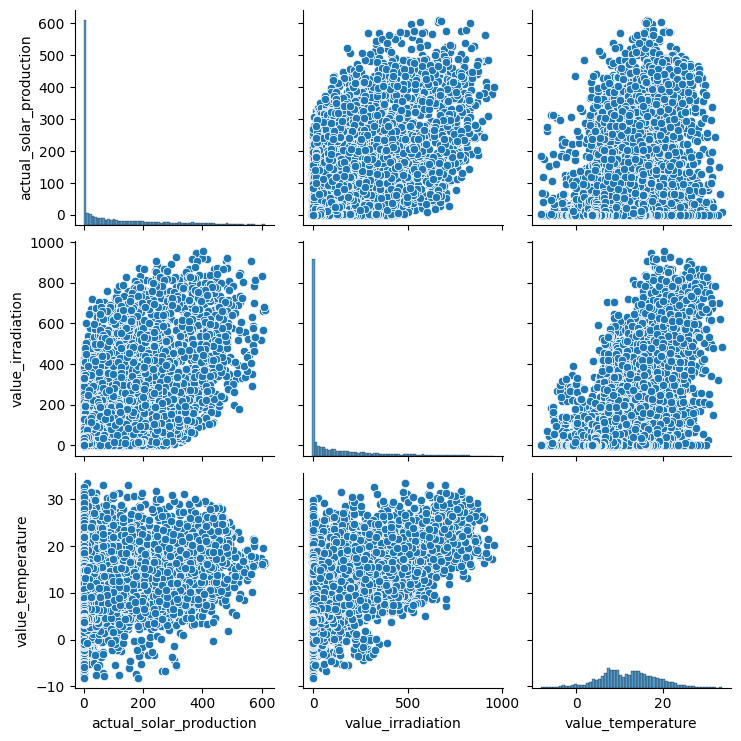

In [12]:
# Scatter plots to visually inspect relationships
sns.pairplot(merged_data_viz[['actual_solar_production', 'value_irradiation', 'value_temperature']])
plt.show()

In [13]:

fig = make_subplots(
    rows=2, cols=1,  
    shared_xaxes=True,  
    subplot_titles=('Temperature vs Time', 'Solar Production vs Time'),
    vertical_spacing=0.1 
)

fig.add_trace(
    go.Scatter(x=merged_data_viz['datetime'], y=merged_data_viz['value_temperature'],
               mode='lines', name='Temperature (°C)'),
    row=1, col=1
)


fig.add_trace(
    go.Scatter(x=merged_data_viz['datetime'], y=merged_data_viz['actual_solar_production'],
               mode='lines', name='Actual Solar Production (kW)'),
    row=2, col=1
)


fig.update_layout(
    title='Solar Production and Temperature Over Time',
    xaxis_title='Datetime',
    height=800,  
    showlegend=True  
)


fig.show()


In [19]:
# Visualization of Solar Production vs Temperature, and vs Irradiation over time (Monthly, Daily, Hourly)   

def plot_interactive_chart(data, value_column_1, value_column_2, title_prefix_1, title_prefix_2):
 

    
    data['datetime'] = pd.to_datetime(data['datetime'])

  
    data['month_num'] = data['datetime'].dt.month
    data['month'] = data['datetime'].dt.strftime('%B')  
    data['day'] = data['datetime'].dt.strftime('%d %B')  
    data['hour'] = data['datetime'].dt.hour

 
    month_order = data[['month', 'month_num']].drop_duplicates().sort_values('month_num')
    month_order_mapping = {month: idx for idx, month in enumerate(month_order['month'], start=1)}

  
    monthly_data = data.groupby('month').agg({
        value_column_1: lambda x: round(x.mean(), 2),
        value_column_2: lambda x: round(x.mean(), 2)
    }).reset_index()
    monthly_data['month_order'] = monthly_data['month'].map(month_order_mapping)
    monthly_data = monthly_data.sort_values('month_order')

    daily_data = data.groupby('day').agg({
        value_column_1: lambda x: round(x.mean(), 2),
        value_column_2: lambda x: round(x.mean(), 2)
    }).reset_index()
    daily_data = daily_data.sort_values('day')

    hourly_data = data.groupby('hour').agg({
        value_column_1: lambda x: round(x.mean(), 2),
        value_column_2: lambda x: round(x.mean(), 2)
    }).reset_index().sort_values('hour')

 
    fig = go.Figure()


    fig.add_trace(go.Scatter(
        x=monthly_data['month'],
        y=monthly_data[value_column_1],
        mode='lines+markers',
        name=f'{title_prefix_1} (Monthly)',
        visible=True,
        hovertemplate=f'{title_prefix_1}: %{{y:.2f}}<br>Month: %{{x}}'
    ))
    fig.add_trace(go.Scatter(
        x=monthly_data['month'],
        y=monthly_data[value_column_2],
        mode='lines+markers',
        name=f'{title_prefix_2} (Monthly)',
        visible=True,
        hovertemplate=f'{title_prefix_2}: %{{y:.2f}}<br>Month: %{{x}}'
    ))


    fig.add_trace(go.Scatter(
        x=daily_data['day'],
        y=daily_data[value_column_1],
        mode='lines+markers',
        name=f'{title_prefix_1} (Daily)',
        visible=False,
        hovertemplate=f'{title_prefix_1}: %{{y:.2f}}<br>Date: %{{x}}'
    ))
    fig.add_trace(go.Scatter(
        x=daily_data['day'],
        y=daily_data[value_column_2],
        mode='lines+markers',
        name=f'{title_prefix_2} (Daily)',
        visible=False,
        hovertemplate=f'{title_prefix_2}: %{{y:.2f}}<br>Date: %{{x}}'
    ))

  
    fig.add_trace(go.Scatter(
        x=hourly_data['hour'],
        y=hourly_data[value_column_1],
        mode='lines+markers',
        name=f'{title_prefix_1} (Hourly)',
        visible=False,
        hovertemplate=f'{title_prefix_1}: %{{y:.2f}}<br>Hour: %{{x}}'
    ))
    fig.add_trace(go.Scatter(
        x=hourly_data['hour'],
        y=hourly_data[value_column_2],
        mode='lines+markers',
        name=f'{title_prefix_2} (Hourly)',
        visible=False,
        hovertemplate=f'{title_prefix_2}: %{{y:.2f}}<br>Hour: %{{x}}'
    ))

    
    fig.update_layout(
        updatemenus=[dict(
            active=0,
            buttons=[
                dict(label='Monthly',
                     method='update',
                     args=[{'visible': [True, True, False, False, False, False]},
                           {'title': f'{title_prefix_1} vs {title_prefix_2} (Monthly)'}]),
                dict(label='Daily',
                     method='update',
                     args=[{'visible': [False, False, True, True, False, False]},
                           {'title': f'{title_prefix_1} vs {title_prefix_2} (Daily)'}]),
                dict(label='Hourly',
                     method='update',
                     args=[{'visible': [False, False, False, False, True, True]},
                           {'title': f'{title_prefix_1} vs {title_prefix_2} (Hourly)'}])
            ]
        )]
    )

   
    fig.update_layout(
        title=f"{title_prefix_1} vs {title_prefix_2}",
        xaxis_title="Time",
        yaxis_title=f"{title_prefix_1} & {title_prefix_2} Values",
        legend_title="Legend"
    )

    fig.show()


plot_interactive_chart(merged_data_viz, 'value_temperature', 'actual_solar_production', 'Temperature', 'Solar Production')

# Plot for Irradiation vs Solar Production
plot_interactive_chart(merged_data_viz, 'value_irradiation', 'actual_solar_production', 'Irradiation', 'Solar Production')


# Prediction

In [38]:
df_prediction = merged_data_viz[['datetime', 'actual_solar_production', 'value_temperature', 'value_irradiation']]


df_prediction = df_prediction.rename(columns={'datetime': 'ds', 'actual_solar_production': 'y'})
df_prediction = df_prediction.drop_duplicates(subset=['ds','y','value_temperature','value_irradiation'], keep='first')


df_prediction=df_prediction[['ds', 'y']]


In [51]:
# df_prediction.to_csv("data_prediction.csv", index=True)

In [39]:
df_prediction['ds'] = pd.to_datetime(df_prediction['ds']).dt.tz_localize(None)

In [43]:

model = Prophet()
model.fit(df_prediction)


future = model.make_future_dataframe(periods=72, freq='h')
forecast = model.predict(future)


forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)




00:33:30 - cmdstanpy - INFO - Chain [1] start processing
00:33:31 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
forecast_date = '2024-12-12'
forecast_for_12_12 = forecast[forecast['ds'].dt.date == pd.to_datetime(forecast_date).date()]



In [45]:
fig = px.line(forecast_for_12_12, x='ds', y='yhat', title='Solar Production Prediction',
              labels={'ds': 'Date', 'yhat': 'Solar Production (kW)'})


fig.show()

In [48]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast_for_12_12)

In [47]:
plot_components_plotly(model, forecast_for_12_12)

# Prediction vs Actual

In [50]:


future = model.make_future_dataframe(periods=72, freq='h')

forecast = model.predict(future)


forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)


start_date = '2024-12-10'
end_date = '2024-12-13'

# Filter actual and forecast data for this range
actual_data = df_prediction[(df_prediction['ds'] >= start_date) & (df_prediction['ds'] <= end_date)]
forecast_data = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

fig = go.Figure()


fig.add_trace(go.Scatter(
    x=actual_data['ds'],
    y=actual_data['y'],
    mode='markers',
    name='Actuals',
    marker=dict(color='red', size=8)
))


fig.add_trace(go.Scatter(
    x=forecast_data['ds'],
    y=forecast_data['yhat'],
    mode='lines',
    name='Forecast',
    line=dict(color='blue', width=2)
))


fig.update_layout(
    title=f'Forecast vs Actuals: {start_date} to {end_date}',
    xaxis_title='Date',
    yaxis_title='Energy (MW)',
    xaxis=dict(
        range=[pd.to_datetime(start_date), pd.to_datetime(end_date)],
        tickangle=45  
    ),
    yaxis=dict(range=[0, 630]),
    template='plotly_dark'
)


fig.show()
